Initialize normal optimization problem

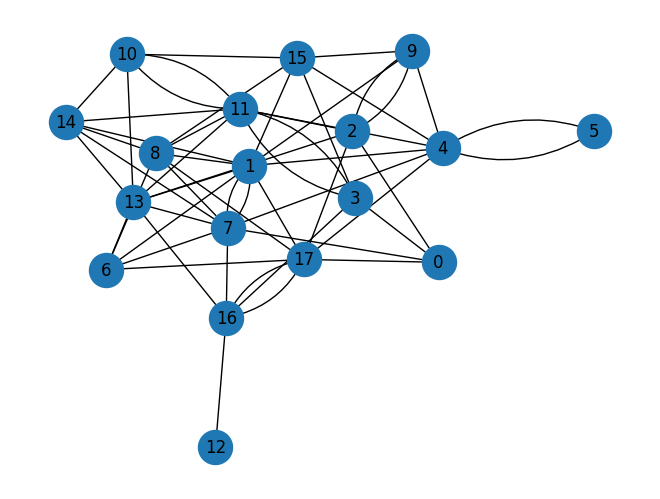

In [24]:
import random
import rustworkx as rx
from rustworkx import is_connected
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np





def make_default_graph(nodes = 4):
    graph = rx.PyGraph()
    graph.add_nodes_from(np.arange(0,nodes,1))
    edge_list = [(0, 1, 1.0), (0, 2, 2.0), (0, 3, 0.5), (1, 2, 1.0), (2, 3, 1.0)]
    """default:
    graph.add_nodes_from(np.arange(0,nodes,1))
    edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]"""
    graph.add_edges_from(edge_list)
    return graph

def make_random_graph(nodes = 5):
    default_weight = 1
    graph = rx.PyGraph()
    rng = np.random.default_rng(seed = 173)
    graph.add_nodes_from(np.arange(0,nodes,1))
    edge_list= [(random.randint(0,nodes-1),random.randint(0,nodes-1),1) for _ in range(2*nodes)]
    
    edge_list = [edge for edge in edge_list if (edge[1],edge[0],1.0) not in edge_list] #remove dupes

    
    graph.add_edges_from(edge_list)

    while not is_connected(graph):
        #naive function iteratively adds edges until the graph is connected. can be immensely improved but runs fast enough
        edge = (random.randint(0,nodes-1),random.randint(0,nodes-1),1)
        mirror_edge = (edge[1],edge[0],1.0)

        if edge not in graph.edge_list() and mirror_edge not in graph.edge_list(): #adding, but avoiding dupes
            graph.add_edges_from([(random.randint(0,nodes-1),random.randint(0,nodes-1),1) for _ in range(1)])

    return graph

num_qubits = 18
depth = 3
graph = make_random_graph(num_qubits)


draw_graph(graph, node_size = 600, with_labels = True)

Create a cost function through a hamiltonian from the graph

In [25]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph):
    """ 
    Convert graph to pauli list.
    Pauli lists are operation instructions for the quantum circuit, and are 
    strings with mostly I-s and some Z-s. 
    They represent Z-operations on some qubits and I-operations on others.
    """

    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"]*len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0],edge[1])
        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)

print("Cost function hamiltonian:", cost_hamiltonian)

Cost function hamiltonian: SparsePauliOp(['ZIIIIIIIIIIIIIIZII', 'IIIIIIZIIIIIIIZIII', 'IIZIIIIIIIIIIZIIII', 'ZIIIIIIIIIIIIIIIZI', 'IIIZIIIZIIIIIIIIII', 'IIIIZIZIIIIIIIIIII', 'IIZIIIIZIIIIIIIIII', 'IZIIZIIIIIIIIIIIII', 'IIIZIIIZIIIIIIIIII', 'IIIIIIIIIIIZIIIIZI', 'IIIIIIIIIIIIIZIIZI', 'IIIIIIIIIIIIIIZIIZ', 'IIIIIIIIIIZIIIIIZI', 'IIIIIIIIIIIIIIIZIZ', 'IIIIZIIIIIIZIIIIII', 'IIIIIIIIIIZIIIIIIZ', 'ZIIIIIIIIIIZIIIIII', 'ZIIIIIIIIIIIIZIIII', 'IIZIIIIIIIIIIIIIZI', 'IIIIIIZIIIIIIIIZII', 'IIIIIIZIIIIIIZIIII', 'IIZIIIIIIZIIIIIIII', 'ZZIIIIIIIIIIIIIIII', 'IIIZIIIIIIZIIIIIII', 'IZIIZIIIIIIIIIIIII', 'IIIIIIIIIZZIIIIIII', 'IIIIIIIIIZIZIIIIII', 'IIIIIIIIIIZIIZIIII', 'IIIIIIIIZIIIIIIZII', 'IIIZIIIIIIIIIIIIZI', 'IZIIIIIIIIZIIIIIII', 'IIIIIIZIIIIIIIZIII', 'IIIIIIIIIIZZIIIIII', 'IIIIIIIIZIIIIIIZII', 'IIIZIIIIIZIIIIIIII', 'IZIIIIIIIIIIIIZIII', 'ZZIIIIIIIIIIIIIIII', 'IIIIZIIZIIIIIIIIII', 'IIIIIIIIIIIIZZIIII', 'IIIIIIZZIIIIIIIIII', 'IIIZZIIIIIIIIIIIII', 'IIIIIIIIIIIIZZIIII', 'IIIIIIIIIIIIZZIIII', 'IIIIIIIIZII

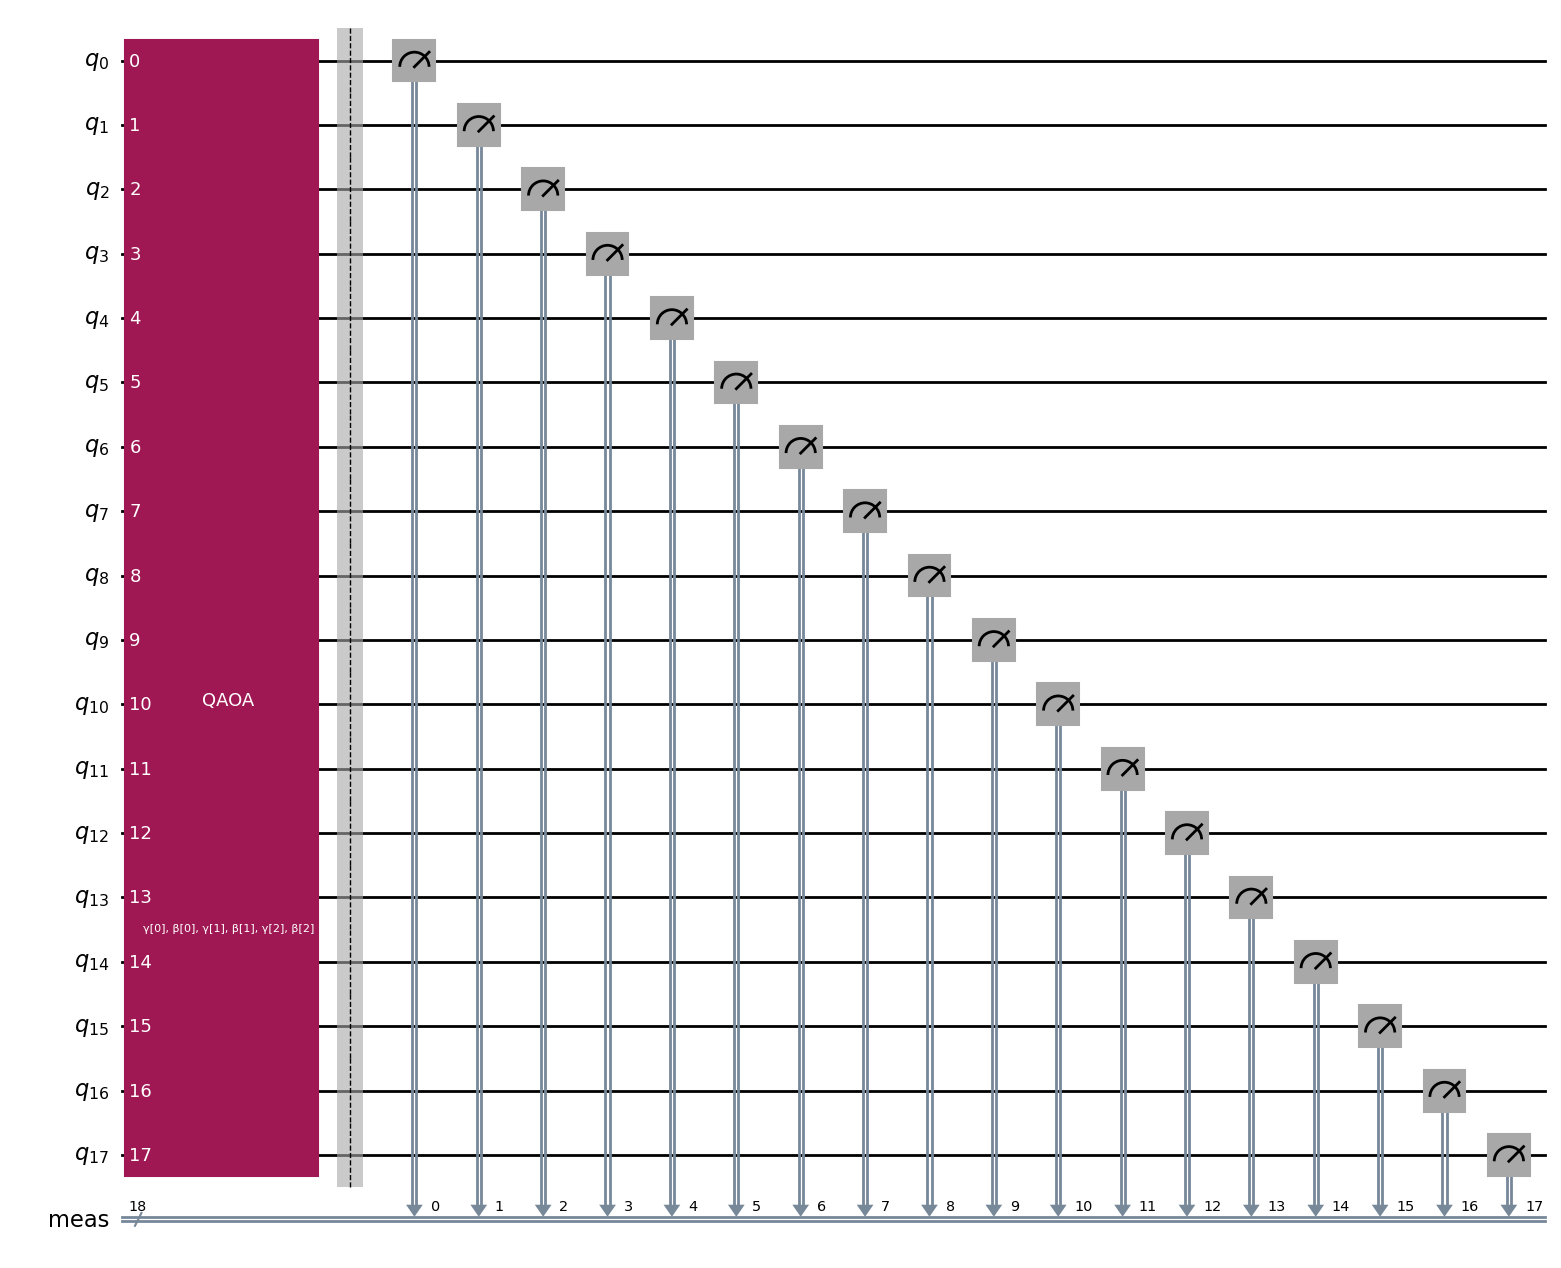

In [26]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator = cost_hamiltonian, reps = depth)
circuit.measure_all()

circuit.draw('mpl')


In [27]:
circuit.parameters



ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(β[2]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1]), ParameterVectorElement(γ[2])])

Optimize the circuit 

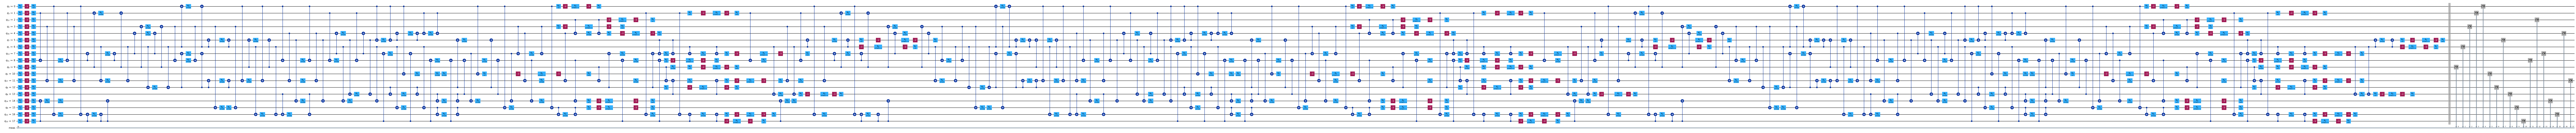

In [28]:
from qiskit_ibm_runtime import fake_provider
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend = GenericBackendV2(num_qubits=num_qubits)

pm = generate_preset_pass_manager(optimization_level=2,backend=backend)

candidate_circuit = pm.run(circuit)

candidate_circuit.draw('mpl', fold=False, idle_wires=False)



Execute using qiskit orimitives - what is a qiskit primitive?

In [35]:
initial_gamma = np.pi
initial_beta = np.pi/2 #todo change 
init_params = [(initial_gamma, initial_beta) for _ in range(depth)]

init_params = [number for tup in init_params for number in tup]


[3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966]


In [36]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    #transoform observable defined on virtual qubits to an observable defined on all physical qubits

    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)

    return cost

print(cost_hamiltonian.apply_layout(candidate_circuit.layout))
print(candidate_circuit.layout)

SparsePauliOp(['IIIIIIZIIIIIIIZIII', 'IIIIIIIIIZIIIIIIZI', 'IZIIIIIIIIIIIIIIIZ', 'IIIIIIZIIIIZIIIIII', 'ZIIZIIIIIIIIIIIIII', 'IIIIIIIIIZZIIIIIII', 'ZZIIIIIIIIIIIIIIII', 'IIIIIIIIIIZIIZIIII', 'ZIIZIIIIIIIIIIIIII', 'IIIIIZIIIIIZIIIIII', 'IIIIIIIIIIIZIIIIIZ', 'IIIIIIIIZIIIIIIIZI', 'IIIIIIIIIIIZZIIIII', 'IIIIIIIIZIIIIIZIII', 'IIIIIZIIIIZIIIIIII', 'IIIIIIIIZIIIZIIIII', 'IIIIIZZIIIIIIIIIII', 'IIIIIIZIIIIIIIIIIZ', 'IZIIIIIIIIIZIIIIII', 'IIIIIIIIIZIIIIZIII', 'IIIIIIIIIZIIIIIIIZ', 'IZIIZIIIIIIIIIIIII', 'IIIIIIZIIIIIIZIIII', 'IIIZIIIIIIIIZIIIII', 'IIIIIIIIIIZIIZIIII', 'IIIIZIIIIIIIZIIIII', 'IIIIZZIIIIIIIIIIII', 'IIIIIIIIIIIIZIIIIZ', 'IIZIIIIIIIIIIIZIII', 'IIIZIIIIIIIZIIIIII', 'IIIIIIIIIIIIZZIIII', 'IIIIIIIIIZIIIIIIZI', 'IIIIIZIIIIIIZIIIII', 'IIZIIIIIIIIIIIZIII', 'IIIZZIIIIIIIIIIIII', 'IIIIIIIIIIIIIZIIZI', 'IIIIIIZIIIIIIZIIII', 'ZIIIIIIIIIZIIIIIII', 'IIIIIIIZIIIIIIIIIZ', 'ZIIIIIIIIZIIIIIIII', 'IIIZIIIIIIZIIIIIII', 'IIIIIIIZIIIIIIIIIZ', 'IIIIIIIZIIIIIIIIIZ', 'IIZIIIIIIIIZIIIIII', 'IZZIIIIIIIIIIIII

In [37]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = []

with Session(backend=backend) as session:

    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    #error supression - is this necessary? my backend is noiseless - ? 
    #if needed, write in later
    """
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"  

    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations="auto"
"""
    result = minimize(
        cost_func_estimator, 
        init_params,
        args= (candidate_circuit, cost_hamiltonian, estimator),
        method = "COBYLA",
        tol = 1e-2
    )
    print(result)



c:\Users\torbj\AppData\Local\Programs\Python\Python310\lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:963: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)
c:\Users\torbj\AppData\Local\Programs\Python\Python310\lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:963: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)
c:\Users\torbj\AppData\Local\Programs\Python\Python310\lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:963: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)
c:\Users\torbj\AppData\Local\Programs\Python\Python310\lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:963: RuntimeWarning: Aer not found using

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.727272727272727
       x: [ 2.912e+00  1.355e+00  2.920e+00  1.289e+00  2.998e+00
            1.477e+00]
    nfev: 43
   maxcv: 0.0


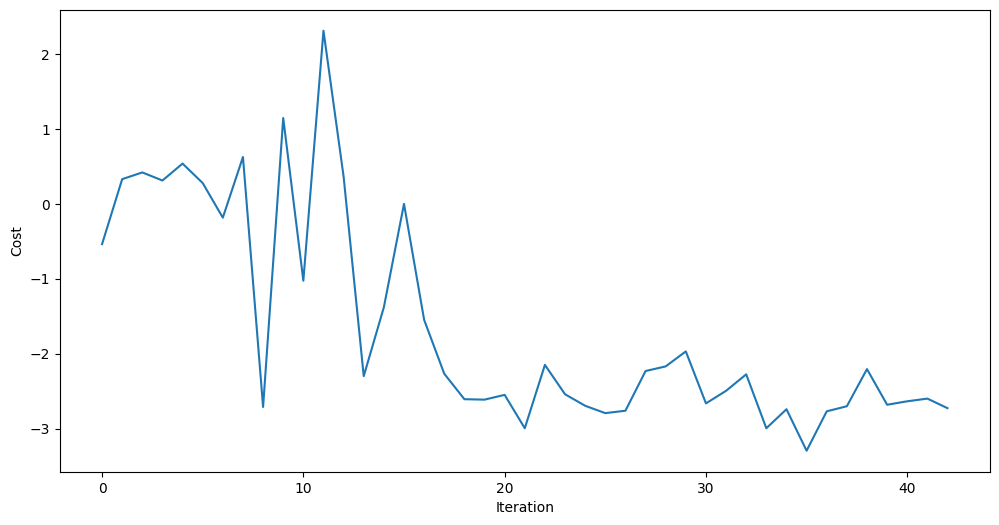

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

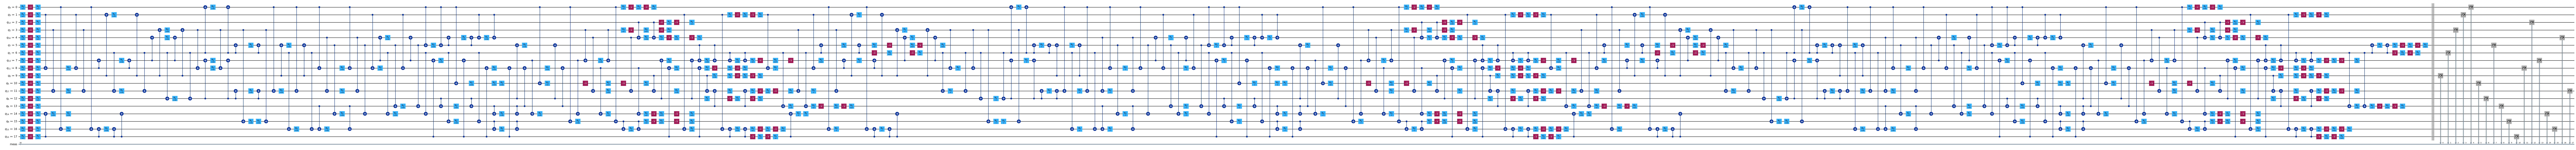

In [39]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold= False, idle_wires=False)

In [40]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
sampler.options.default_shots=10000

pub = (optimized_circuit,)
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
print(counts_int)
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

c:\Users\torbj\AppData\Local\Programs\Python\Python310\lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:963: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)


{225966: 1, 241375: 1, 89646: 1, 221806: 2, 31955: 1, 156377: 1, 3361: 1, 69213: 1, 247057: 2, 184847: 1, 219495: 1, 71667: 1, 129604: 1, 13352: 2, 141815: 1, 164179: 1, 140693: 1, 1125: 1, 108767: 1, 120976: 1, 92820: 1, 204630: 1, 161525: 1, 84607: 1, 127075: 1, 211590: 1, 73302: 1, 15715: 2, 5738: 1, 10092: 1, 61717: 1, 81685: 2, 183279: 1, 64325: 1, 240286: 1, 148704: 1, 33697: 1, 21929: 2, 30746: 1, 5594: 3, 148656: 1, 235480: 1, 205927: 1, 104614: 1, 79086: 1, 30807: 1, 24748: 1, 129121: 2, 168563: 1, 243502: 2, 246881: 2, 84706: 1, 139228: 1, 42859: 1, 220036: 1, 47870: 1, 42906: 1, 187854: 1, 207922: 1, 83930: 1, 16114: 1, 30315: 1, 167138: 1, 256531: 2, 243554: 1, 107433: 1, 90473: 1, 243436: 1, 75235: 1, 27240: 2, 160750: 1, 218876: 1, 254747: 1, 140012: 1, 95045: 1, 31011: 1, 86297: 1, 138455: 1, 203462: 2, 112622: 1, 116770: 1, 250981: 1, 19575: 1, 138439: 1, 193868: 1, 53031: 1, 36071: 1, 75639: 1, 48886: 3, 221530: 1, 187424: 1, 141800: 2, 137198: 1, 238636: 1, 23082: 2, 

In [41]:
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())

most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0]


In [42]:
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

C:\Users\torbj\AppData\Local\Temp\ipykernel_40124\2624617538.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


TypeError: only length-1 arrays can be converted to Python scalars

Error in callback <function flush_figures at 0x000001EAF9BE8B80> (for post_execute):


KeyboardInterrupt: 

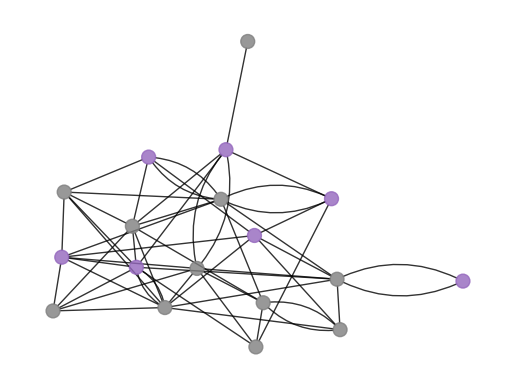

In [43]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(graph, most_likely_bitstring)

In [44]:
from typing import Sequence
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))


cut_value= evaluate_sample(most_likely_bitstring, graph)
print('The value of the cut is:', cut_value)

The value of the cut is: 32


CPLEX implementation of the same problem

-2x_0*x_2-2x_0*x_3-2x_0*x_7-2x_0*x_17-2x_1*x_4-2x_1*x_6-2x_1*x_7-2x_1*x_8-2x_1*x_9-2x_1*x_13-2x_1*x_14-2x_1*x_15-2x_1*x_17-2x_2*x_9-2x_2*x_11-2x_2*x_13-2x_2*x_17-2x_3*x_11-2x_3*x_15-2x_3*x_16-2x_4*x_5-2x_4*x_7-2x_4*x_9-2x_4*x_11-2x_4*x_15-2x_4*x_17-2x_6*x_7-2x_6*x_8-2x_6*x_13-2x_6*x_17-2x_7*x_8-2x_7*x_13-2x_7*x_14-2x_7*x_16-2x_8*x_11-2x_8*x_14-2x_8*x_15-2x_8*x_17-2x_9*x_15-2x_10*x_11-2x_10*x_13-2x_10*x_14-2x_10*x_15-2x_11*x_13-2x_11*x_14-2x_12*x_16-2x_13*x_14-2x_13*x_16-2x_16*x_17+4x_0+9x_1+5x_2+4x_3+7x_4+x_5+5x_6+8x_7+7x_8+4x_9+4x_10+7x_11+x_12+8x_13+6x_14+6x_15+5x_16+7x_17
solution for: MaxCut
objective: 36
status: OPTIMAL_SOLUTION(2)
x_3 = 1
x_5 = 1
x_7 = 1
x_8 = 1
x_9 = 1
x_10 = 1
x_12 = 1
x_13 = 1
x_17 = 1
Result bitstring quantum: [0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0]
       Result classical:  [0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1]
Same solution False


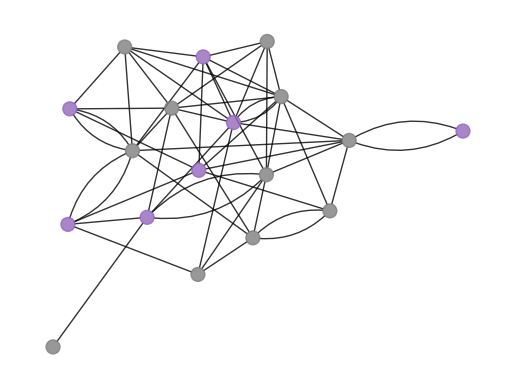

In [45]:
import cplex
from docplex.mp.model import Model
from rustworkx import NoEdgeBetweenNodes


mdl = Model(name="MaxCut")

variables = mdl.binary_var_list(len(graph), name='x')


objective = 0

for i,var in enumerate(variables):
    for j,var2 in enumerate(variables):
        if i != j and i> j:  
            try:
                graph.get_edge_data(i,j)
                objective += var + var2 - 2*var*var2
            except NoEdgeBetweenNodes:
                pass

print(objective)
mdl.maximize(objective)

solution = mdl.solve()


solution.display()

print("Result bitstring quantum:", most_likely_bitstring)

bitstring = [int(var.solution_value) for var in variables]
print("       Result classical: ", bitstring)
    
bools = [a==b for a,b in zip(bitstring,most_likely_bitstring)]
plot_result(graph, most_likely_bitstring)
    
print("Same solution", all(bools))
